In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [4]:
def factor(df, window=96):
    """
    重构后的因子：避免未来数据，保持时效性
    核心改进：
      1. 使用滚动窗口计算替代日级分组
      2. 特征计算仅使用历史数据
      3. 因子值实时更新
    """
    df = df.copy()
    
    # 计算基础波动率指标（无未来数据）
    df['range'] = (df['high'] - df['low']) / df['open']
    df['fractal'] = df['range'].rolling(5).std() / df['range'].rolling(20).std().replace(0, 1e-5)
    
    # 实时计算重心指标（滚动窗口替代日级分组）
    df['is_up'] = (df['close'] > df['open']).astype(int)
    df['is_down'] = (df['close'] < df['open']).astype(int)
    
    # 修正重心计算函数
    def calc_center(group, direction):
        """计算给定方向的滚动重心"""
        # 创建结果数组
        results = np.full(len(group), np.nan)
        
        # 获取方向列
        dir_col = f'is_{direction}'
        
        # 使用expanding窗口计算重心
        for i in range(4, len(group)):  # min_periods=4
            window_data = group.iloc[:i+1]  # 获取到当前行的所有数据
            
            # 过滤当前方向的数据点
            mask = window_data[dir_col] == 1
            if not mask.any():
                continue
                
            # 计算权重：分形维度 * 成交量
            weights = window_data.loc[mask, 'fractal'] * window_data.loc[mask, 'volume']
            
            # 计算时间位置权重
            time_idx = np.arange(len(window_data))[mask]
            weighted_idx = time_idx * weights
            
            # 计算重心位置
            center = weighted_idx.sum() / weights.sum()
            results[i] = center
            
        return results
    
    # 按日分组计算重心
    df['G_u'] = df.groupby(pd.Grouper(freq='D')).apply(
        lambda g: calc_center(g, 'up')
    ).explode().values
    
    df['G_d'] = df.groupby(pd.Grouper(freq='D')).apply(
        lambda g: calc_center(g, 'down')
    ).explode().values
    
    # 滚动平均分形维度
    df['avg_fractal'] = df['fractal'].rolling(window=24, min_periods=12).mean()
    
    # 准备回归数据集（仅使用历史数据）
    regression_data = []
    for idx in range(window, len(df)):
        current = df.iloc[idx]
        
        # 检查必要特征是否可用
        if pd.isna(current['G_u']) or pd.isna(current['G_d']) or pd.isna(current['avg_fractal']):
            regression_data.append(np.nan)
            continue
            
        # 使用历史窗口训练（避免未来数据）
        train_data = df.iloc[max(0, idx-window):idx]
        train_data = train_data.dropna(subset=['G_u', 'G_d', 'avg_fractal'])
        
        if len(train_data) < 10:
            regression_data.append(np.nan)
            continue
            
        # 回归模型训练
        X = train_data[['G_u', 'avg_fractal']].values
        y = train_data['G_d'].values
        model = LinearRegression().fit(X, y)
        
        # 当前点预测（仅使用当前已知特征）
        pred_G_d = model.predict([[current['G_u'], current['avg_fractal']]])[0]
        residual = current['G_d'] - pred_G_d
        
        # 分形波动调整
        fractal_level = current['avg_fractal']
        regression_data.append(residual * fractal_level)
    
    # 构建因子序列
    factor_series = pd.Series(np.nan, index=df.index)
    factor_series.iloc[window:] = regression_data
    factor_series = factor_series.fillna(method='ffill').fillna(0)
    
    # 后处理
    factor_series = -factor_series
    # factor_series[np.abs(factor_series) > 10] = 0
    
    return factor_series

# 测试因子表现


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.028932
   Rank_IC (Spearman): 0.013238
📊 信息比率:
   IR: 0.284372
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 131035
   因子列: factor
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------


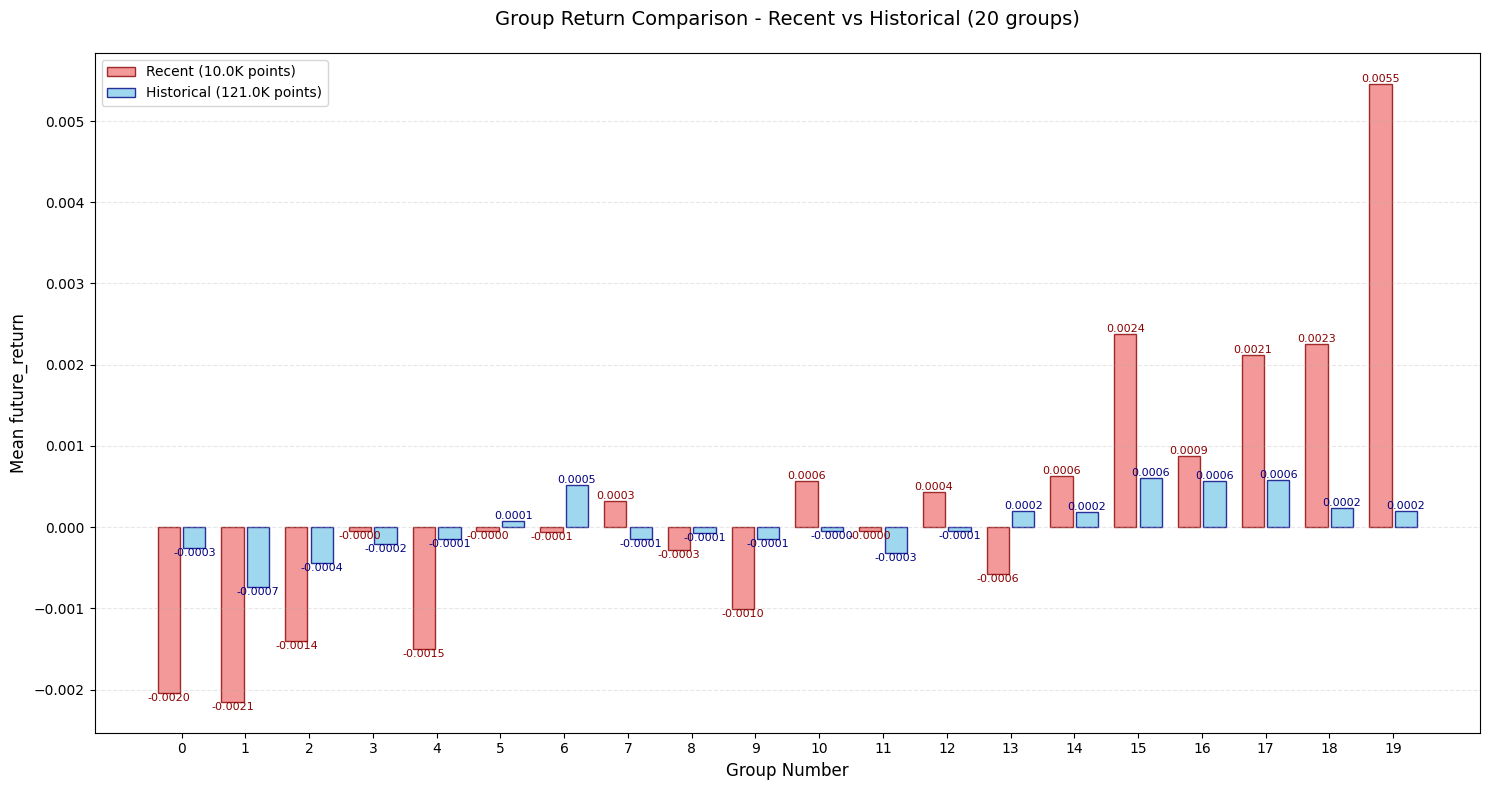

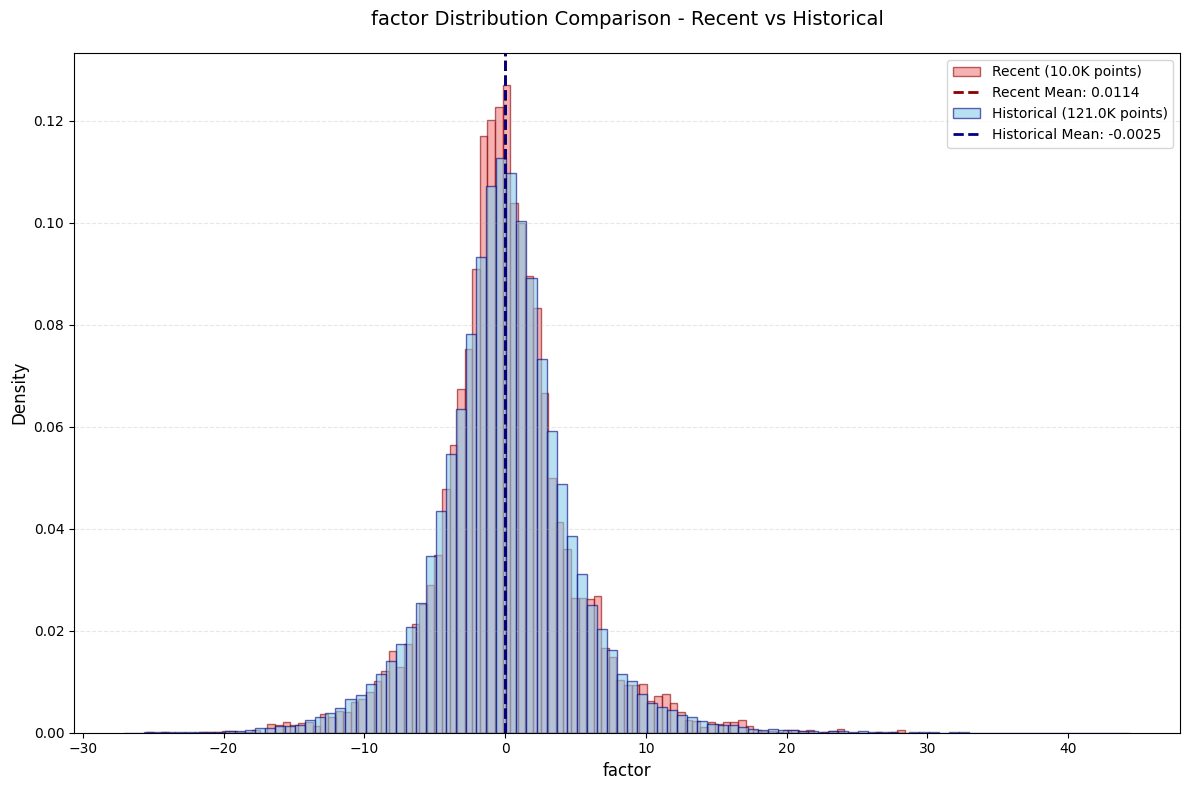

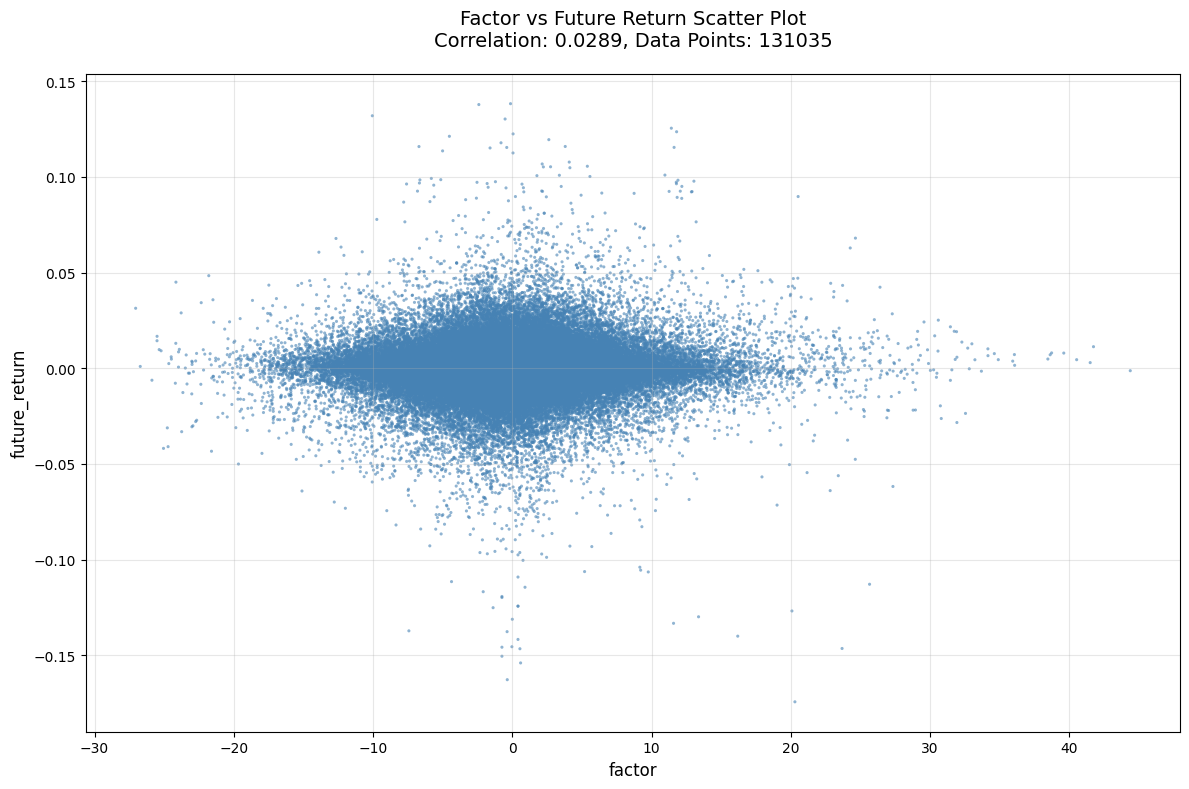

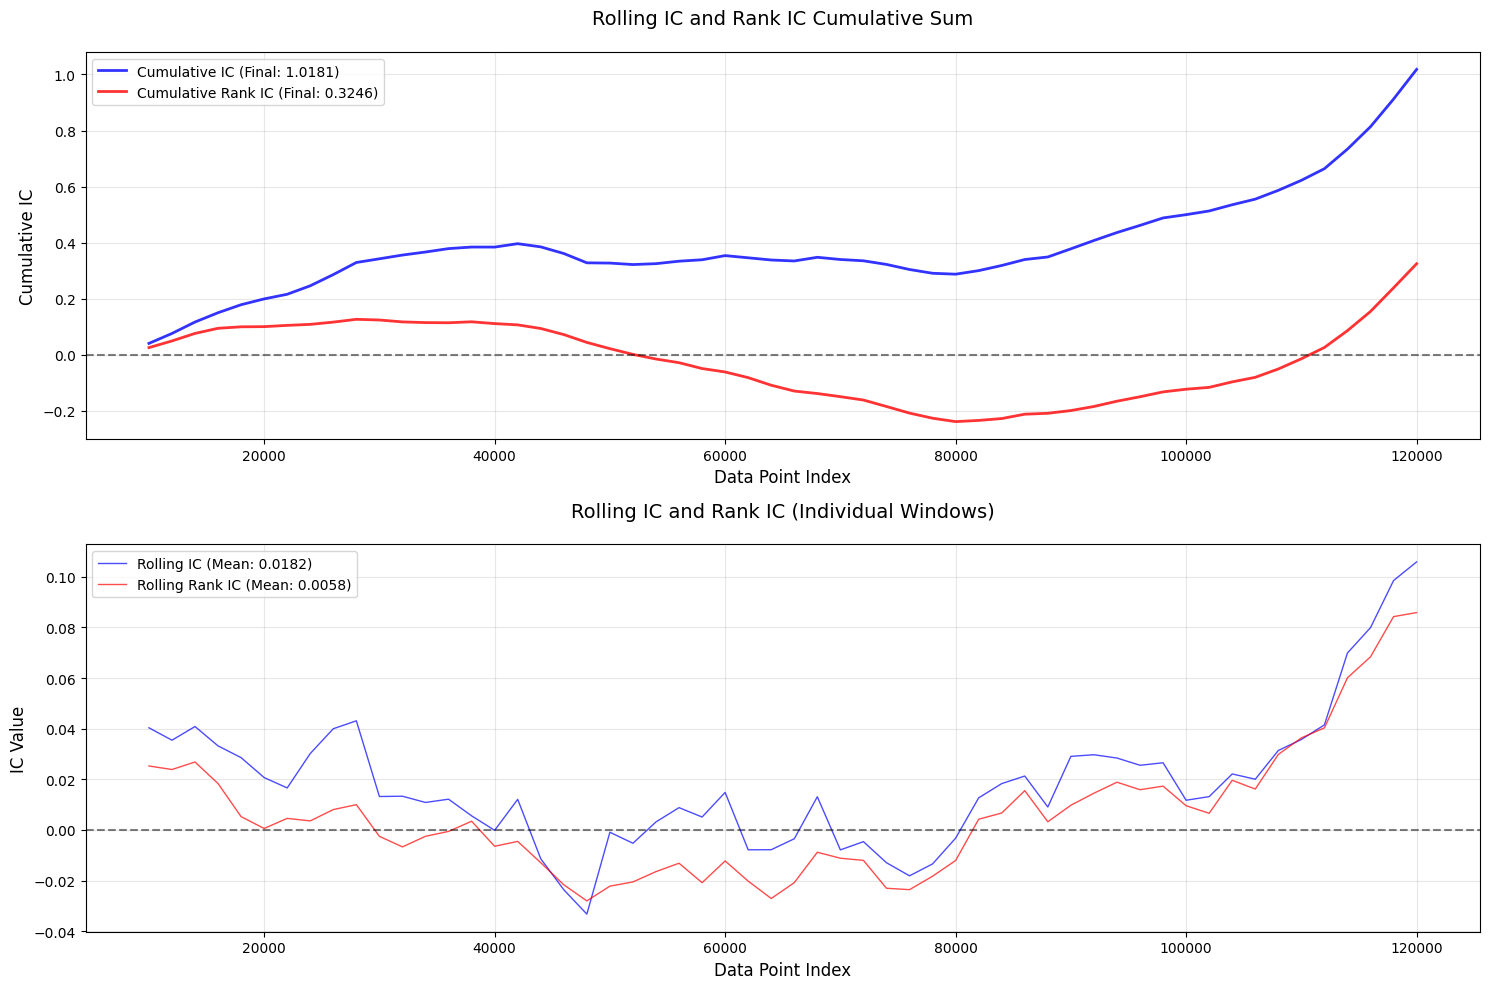

✅ 已显示 4 个图片
----------------------------------------


In [5]:
evaluator.set_factor(
    factor_func=lambda df: factor(df),
    factor_name='factor'
)

result=evaluator.run_full_evaluation(run_stationarity_test=False)

In [6]:
result['information_ratio']['group_correlations']
# 这表示不同分组之间的相关性，通常用于评估因子在不同市场状态下的表现一致性。
# 如果相关性较高，说明因子在不同市场状态下表现一致；如果相关性较低，说明因子在不同市场状态下表现差异较大。

[-0.011980357881641882,
 0.016254797846041277,
 0.007928436082807076,
 -0.01564302206067798,
 -0.005046436155081281,
 -0.0075935024594546595,
 0.010298419246371439,
 0.014448548115629713,
 0.0007612548625830271,
 0.028575153374723623]

In [7]:
print(result)

{'correlation_analysis': {'IC': 0.02893235746525304, 'Rank_IC': 0.013237647528063261}, 'information_ratio': {'IR': 0.2843717148123717, 'group_correlations': [-0.011980357881641882, 0.016254797846041277, 0.007928436082807076, -0.01564302206067798, -0.005046436155081281, -0.0075935024594546595, 0.010298419246371439, 0.014448548115629713, 0.0007612548625830271, 0.028575153374723623], 'n_groups': 10}, 'group_analysis': {'group_stats':        val_min  val_max  val_mean  return_mean  return_std  count
group                                                            
0     -27.0509  -7.8094  -10.8169      -0.0004      0.0129   6552
1      -7.8091  -5.4856   -6.5179      -0.0008      0.0128   6552
2      -5.4854  -4.2151   -4.8058      -0.0005      0.0123   6552
3      -4.2150  -3.3129   -3.7452      -0.0001      0.0114   6551
4      -3.3128  -2.5717   -2.9292      -0.0003      0.0113   6552
5      -2.5716  -1.9424   -2.2541       0.0000      0.0119   6552
6      -1.9423  -1.4211   -1.6767    